In [358]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [359]:
batch_size = 256
learning_rate = 0.001
num_epoch = 40

In [360]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [361]:
# 0 : 300
# 1 : 6742 
# 2 : 5958
# sum : 13000
mnist_train2 = []
mnist_test2 = []
count_zero = 0
count_one = 0
count_two = 0 
trash = 0
for i in mnist_train:
    if i[1] == 1:
        count_one = count_one + 1
        mnist_train2.append(i)
    if i[1] == 2:
        count_two = count_two + 1
        mnist_train2.append(i)
    if i[1] == 0:
        count_zero = count_zero + 1
        if count_zero <= 300:
            mnist_train2.append(i)
        else:
            trash = trash +1
for i in mnist_test:
    if i[1] == 0 or i[1] == 1 or i[1] == 2:
        mnist_test2.append(i)
        
print(len(mnist_train))
print(len(mnist_train2))


print("zero count : ",count_zero)
print("one count : ",count_one)
print("two count : ",count_two)

print(trash)

60000
13000
zero count :  5923
one count :  6742
two count :  5958
5623


tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

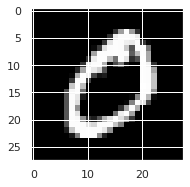

In [362]:
print(mnist_train2[0][0].view(28,-1))
plt.subplot(1,2,1)
plt.imshow(torch.squeeze(mnist_train2[0][0].view(28,-1)),cmap='gray')

In [363]:
train_loader = torch.utils.data.DataLoader(mnist_train2,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test2,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [364]:
z = []

In [365]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder1 = (nn.Linear(28*28,128))
        self.encoder2 = (nn.Linear(128,64))
        self.encoder3 = (nn.Linear(64,32))
        self.encoder4 = (nn.Linear(32,16))
        self.encoder5 = (nn.Linear(16,8))
        self.encoder6 = (nn.Linear(8,2))
        
        self.decoder = (nn.Linear(2,8))   
        self.decoder1 = (nn.Linear(8,16))   
        self.decoder2 = (nn.Linear(16,32))   
        self.decoder3 = (nn.Linear(32,64))
        self.decoder4 = (nn.Linear(64,128))
        self.decoder5 = (nn.Linear(128,28*28))
                
    def forward(self,x):
        x = x.view(batch_size,-1)
        x = F.relu(self.encoder1(x))
        x = F.relu(self.encoder2(x))
        x = F.relu(self.encoder3(x))
        x = F.relu(self.encoder4(x))
        x = F.relu(self.encoder5(x))
        x = F.tanh(self.encoder6(x))
        
        v = x
        
        x = F.relu(self.decoder(x))
        x = F.relu(self.decoder1(x))
        x = F.relu(self.decoder2(x))
        x = F.relu(self.decoder3(x))
        x = F.relu(self.decoder4(x))
        x = F.relu(self.decoder5(x))
        
        out = x.view(batch_size,1,28,28)
        return out, v

In [366]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cpu


In [367]:
for i in range(num_epoch):
    overall_loss = 0
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        
        optimizer.zero_grad()
        output, v = model.forward(x)
        loss = loss_func(output,x)
        loss.backward()
        optimizer.step()
        overall_loss = overall_loss + loss.item()
    print("epoch : ", i)
    print("overall_loss : ", overall_loss)

/home/roy/.local/lib/python3.8/site-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch :  0
overall_loss :  3.7894755005836487
epoch :  1
overall_loss :  3.339038211852312
epoch :  2
overall_loss :  2.8919377736747265
epoch :  3
overall_loss :  2.7164191715419292
epoch :  4
overall_loss :  2.6169343292713165
epoch :  5
overall_loss :  2.482765167951584
epoch :  6
overall_loss :  2.4103413708508015
epoch :  7
overall_loss :  2.351359285414219
epoch :  8
overall_loss :  2.283584527671337
epoch :  9
overall_loss :  2.2262107878923416
epoch :  10
overall_loss :  2.205697786062956
epoch :  11
overall_loss :  2.189035814255476
epoch :  12
overall_loss :  2.1751173958182335
epoch :  13
overall_loss :  2.1679954901337624
epoch :  14
overall_loss :  2.14467116817832
epoch :  15
overall_loss :  2.1243995018303394
epoch :  16
overall_loss :  2.0737589076161385
epoch :  17
overall_loss :  2.0148470029234886
epoch :  18
overall_loss :  1.9903707541525364
epoch :  19
overall_loss :  1.9711388312280178
epoch :  20
overall_loss :  1.953727524727583
epoch :  21
overall_loss :  1.94

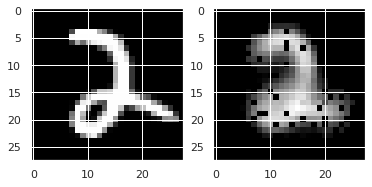

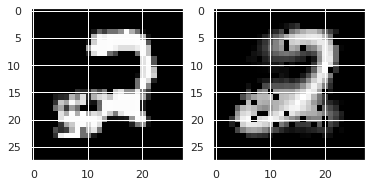

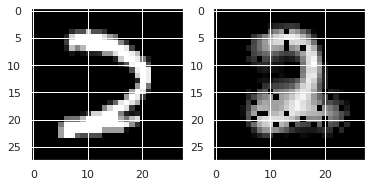

In [368]:
# training data result
out_img = torch.squeeze(output.cpu().data)
for i in range(3):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [369]:
# feature vector of test data to coordinate
lab = []
feat = []
with torch.no_grad():
  for i in range(1):
      for j,[image,label] in enumerate(test_loader):
          x = image.to(device)

          optimizer.zero_grad()
          output,z = model.forward(x)
          #label = label.reshape(256,-1)
          #z = torch.cat([z,label],dim=1)
          for i in range(len(z)):
                feat.append(list(z[i]))
                lab.append(int(label[i]))
      if j % 1000 == 0:
          print(loss)
print(len(z))
print(z)
print(len(feat))
print(len(lab))
print(len(test_loader))

256
tensor([[-0.1772,  0.3453],
        [ 0.9758,  0.5937],
        [-0.1246,  0.4266],
        [-0.1296,  0.4314],
        [ 0.9085,  0.3992],
        [-0.1324,  0.3625],
        [-0.2026,  0.3596],
        [ 0.9788,  0.5239],
        [ 0.9816,  0.5975],
        [-0.1500,  0.3795],
        [ 0.9579,  0.4821],
        [-0.1157,  0.4118],
        [-0.1144,  0.4241],
        [ 0.8840,  0.5717],
        [-0.2269,  0.4660],
        [-0.2686,  0.6906],
        [ 0.6161,  0.6583],
        [ 0.5842,  0.3378],
        [-0.1451,  0.4557],
        [ 0.3660,  0.4904],
        [-0.1553,  0.3194],
        [-0.2041,  0.2863],
        [ 0.3854,  0.7390],
        [ 0.9512,  0.5068],
        [ 0.9216,  0.4219],
        [-0.2281,  0.4054],
        [-0.2173,  0.6650],
        [ 0.5882,  0.6844],
        [ 0.1007,  0.6164],
        [-0.1446,  0.4129],
        [-0.5829,  0.1994],
        [ 0.9899,  0.6612],
        [ 0.9911,  0.6595],
        [-0.7573, -0.3114],
        [-0.0338,  0.6849],
        [ 0.9707

torch.Size([256, 28, 28])


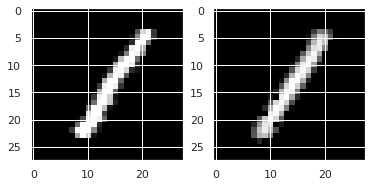

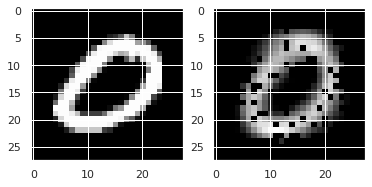

In [370]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(2):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [371]:
from sklearn.cluster import DBSCAN

#########cluster
feat2 = []
lab2 = []
for i in range(len(feat)):
    if lab[i] == 0 or lab[i] == 1 or lab[i] == 2:
        lab2.append(lab[i])
        feat2.append(feat[i])
print(len(lab2))
print(len(lab))

################################Hyperparameter##############33
eps = 0.06
min_samples = 20
model2 = DBSCAN(eps=eps, min_samples=min_samples)
y_predict = model2.fit(feat2)
###############################################################3
noise_count = 0
ok = 0
ko = 0
for i in range(len(y_predict.labels_)):
    if y_predict.labels_[i] != -1 :
        print(y_predict.labels_[i] + 1,lab2[i])
        if y_predict.labels_[i] + 1 == lab2[i]:
            ok = ok + 1
        else:
            ko = ko + 1
    else:
        noise_count = noise_count + 1
        
print("#eps, min_samples : ", eps,min_samples)
print("#cluster count, noise count : ", max(y_predict.labels_)+1, noise_count)
#print("#",((noise_count + ko) / (ok+ko+noise_count)) * 100)

#eps, min_samples :  0.05 5
#cluster count, noise count :  4 80
#95.51241247612985


3072
3072
1 2
2 1
1 0
2 1
1 0
1 0
2 1
1 0
1 0
1 2
1 2
2 1
1 2
1 2
1 0
2 1
1 0
1 0
1 2
2 1
1 2
1 2
2 1
1 0
1 2
2 1
1 2
1 0
2 1
1 0
2 1
1 2
1 0
1 2
1 0
1 2
1 2
2 1
1 0
1 2
1 0
1 0
1 0
2 1
1 2
2 1
2 1
1 2
1 0
1 2
1 2
1 2
2 1
1 2
1 2
1 2
1 0
1 2
1 2
1 2
2 1
2 1
1 0
1 0
2 1
1 2
1 2
1 2
2 1
1 2
1 2
1 0
1 0
1 0
1 2
1 2
1 0
1 2
1 0
1 0
1 2
1 2
1 2
1 0
2 1
2 1
1 2
2 1
2 1
2 1
1 0
2 1
2 1
1 2
1 2
1 0
1 2
1 0
1 0
1 2
2 1
1 2
2 1
1 2
1 2
1 2
1 0
2 1
1 2
1 2
1 2
1 0
2 1
1 0
1 0
1 0
1 2
1 2
2 1
1 2
1 0
1 2
2 1
1 2
2 1
1 0
2 1
1 0
1 2
1 0
1 2
3 1
1 2
1 2
1 2
2 1
1 0
2 1
1 2
2 1
1 2
1 0
1 0
1 2
1 2
1 0
1 0
1 0
1 0
1 0
1 2
1 0
1 0
1 0
1 0
1 2
1 0
1 2
1 2
2 1
1 0
1 2
1 2
1 2
1 2
1 2
1 0
1 2
1 0
1 2
2 1
1 2
1 0
1 2
1 0
2 1
2 1
1 2
2 1
1 0
1 0
1 0
1 2
2 1
1 0
1 0
1 0
2 1
1 2
1 2
1 2
1 2
1 0
1 2
2 1
1 0
2 1
1 0
1 2
3 1
2 1
1 2
2 1
1 0
1 2
1 2
1 0
1 2
2 1
1 0
1 2
2 1
2 1
1 2
1 2
2 1
2 1
2 1
1 2
1 0
2 1
2 1
1 0
1 0
1 2
1 2
1 2
1 2
1 0
1 2
1 2
1 0
1 2
2 1
1 2
1 2
1 0
1 0
2 1
1 0
1 2
3 1
1 2
1 2
1 2
1 2
1 2
1 

1 2
2 1
1 0
1 2
2 1
1 0
1 2
1 2
1 0
2 1
1 2
2 1
1 0
1 2
1 0
1 2
1 0
1 0
1 2
1 0
2 1
1 0
2 1
1 2
1 2
1 2
2 1
1 0
2 1
2 1
2 1
1 0
2 1
1 2
1 0
2 1
1 2
1 0
2 1
1 2
1 2
1 2
2 1
1 2
1 2
1 2
2 1
1 2
2 1
2 1
1 0
1 0
1 0
2 1
2 1
1 2
1 0
1 0
2 1
1 0
1 0
1 0
2 1
1 0
2 1
1 2
1 2
1 0
1 0
2 1
1 2
1 0
2 1
1 2
1 0
2 1
1 2
1 2
1 2
1 2
1 0
1 0
2 1
1 0
1 0
1 0
2 1
1 0
1 0
1 2
2 1
2 1
1 2
1 0
2 1
1 2
2 1
1 0
1 2
2 1
1 2
1 2
1 0
2 1
1 2
1 0
2 1
1 2
1 0
2 1
1 2
2 1
1 2
1 2
1 0
1 2
1 2
2 1
1 2
2 1
1 0
2 1
2 1
1 0
2 1
2 1
1 0
1 0
2 1
1 0
2 1
2 1
1 0
2 1
1 2
1 2
2 1
1 2
2 1
2 1
1 2
1 0
1 0
2 1
1 2
1 2
1 2
2 1
1 0
1 0
1 2
1 0
1 2
1 0
2 1
1 2
2 1
1 0
2 1
1 2
1 0
1 2
2 1
2 1
1 2
2 1
1 2
1 2
1 0
1 2
1 0
2 1
2 1
1 2
1 0
1 0
1 0
1 2
2 1
1 0
1 0
2 1
1 2
1 0
2 1
1 2
1 0
2 1
1 2
1 2
1 2
1 0
1 0
2 1
1 0
1 2
1 0
2 1
1 0
1 0
2 1
1 0
1 2
2 1
2 1
1 2
1 0
1 2
1 0
1 0
2 1
1 0
1 0
1 2
1 2
1 2
1 0
1 0
2 1
1 2
2 1
1 0
1 0
1 2
2 1
1 2
2 1
1 2
1 0
1 0
1 2
1 0
1 2
1 0
1 2
1 0
1 2
1 0
1 0
1 0
1 2
1 2
1 0
2 1
2 1
1 0
2 1
1 0
1 0
1 2


3072 3072


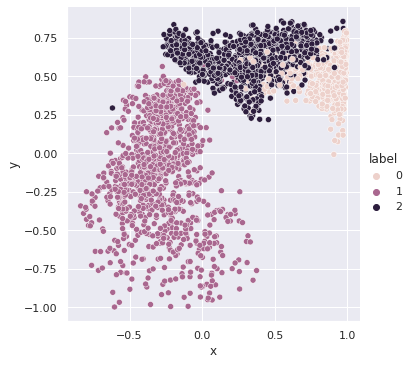

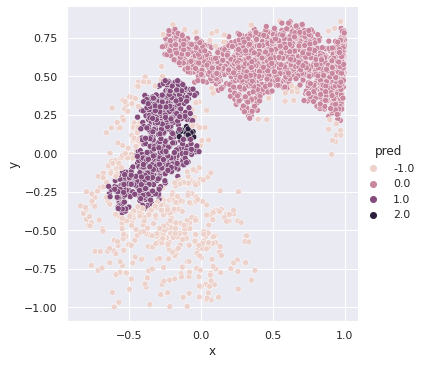

In [372]:
# visualization
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
print(len(feat2),len(y_predict.labels_))
x = []
y = []
pred = []
for i in range(len(feat2)):
    x.append(float(feat2[i][0]))
    y.append(float(feat2[i][1]))
    pred.append(float(y_predict.labels_[i]))
# DataFrame 만들기

body = pd.DataFrame(
    {'x': x, 'y': y, 'pred' : pred, 'label' : lab2}
)
#print(body.body())
import matplotlib.pylab as plt

sns.relplot(x='x',y='y', hue="label", data=body) # label
sns.relplot(x='x',y='y', hue="pred", data=body) # cluster result

# plt.legend(loc = "best")
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()